VGGNet MODEL IMPLEMENTATION - FER2013

IMPORTING LIBRARIES

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.utils import np_utils

VGG - LOADING DATA - FER2013

In [2]:
# Set the path to the folder containing images
data_path = "C:/Users/HP/Desktop/MSc Thesis/DATASETS/FER2013_complete"

# Defining the emotion classes
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy',  'Neutral', 'Sad', 'Surprise']

# Set the image size and batch size
image_size = (48, 48)
batch_size = 32

VGG - DATA PREPROCESSING - FER2013

In [3]:
def load_data():
    images = []
    labels = []
    for emotion_class in emotion_classes:
        class_path = os.path.join(data_path, emotion_class)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert('L')  # Convert the images to grayscale
            image = image.resize(image_size)
            image = np.array(image)
            image = np.stack([image, image, image], axis=-1)
            labels.append(emotion_classes.index(emotion_class))
    return np.array(images), np.array(labels)

# Load the images and labels
images, labels = load_data()

# Split the data into training, validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Normalize the pixel values between 0 and 1
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert the labels to one-hot encoding
num_classes = len(emotion_classes)
y_train = np.eye(num_classes)[y_train]
y_val = np.eye(num_classes)[y_val]
y_test = np.eye(num_classes)[y_test]

VGG MODEL TRAINING - FER2013

In [ ]:
import psutil
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.callbacks import Callback
from keras.layers import Input
from keras.optimizers import Adam

# Function to convert bytes to megabytes
def bytes_to_megabytes(bytes):
    return bytes / (1024.0 ** 2)

# Initial RAM usage
initial_memory = psutil.virtual_memory().used
print(f"Initial RAM used: {bytes_to_megabytes(initial_memory):.2f} MB")

# Create the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_size[0], image_size[1], 3)))

# Make only the top layers of VGG19 trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base VGG19 model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# RAM usage after model creation
after_creation_memory = psutil.virtual_memory().used
print(f"RAM used after model creation: {bytes_to_megabytes(after_creation_memory):.2f} MB")
print(f"Approximate RAM used during model creation: {bytes_to_megabytes(after_creation_memory - initial_memory):.2f} MB")

# Define the callback class
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        self.test_acc.append(acc)  
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

# Create the TestCallback instance
test_callback = TestCallback((X_test, y_test))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model and capture history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[test_callback], verbose=1)

# RAM usage after training
after_training_memory = psutil.virtual_memory().used
print(f"RAM used after model training: {bytes_to_megabytes(after_training_memory):.2f} MB")
print(f"Approximate RAM used during training: {bytes_to_megabytes(after_training_memory - after_creation_memory):.2f} MB")

VGG - ACCURACY vs EPOCH PLOT - FER2013

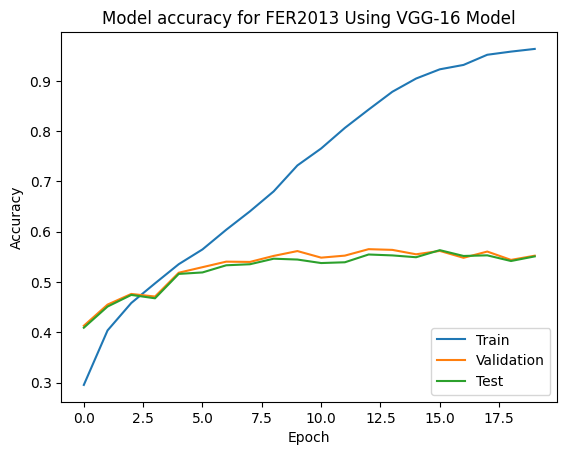

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(test_callback.test_acc)  # Test accuracy
plt.title('Model accuracy for FER2013 Using VGG-16 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='lower right')
plt.show()

VGG - ERROR RATE PLOT - FER2013

In [7]:
# Plot error rate vs epochs
import matplotlib.pyplot as plt
plt.plot(1 - np.array(history.history['accuracy']))
plt.plot(1 - np.array(history.history['val_accuracy']))
plt.plot(1 - np.array(test_callback.test_acc))  # Plot test error rate
plt.title('Error Rate vs Epochs for FER2013 Dataset Using VGG-16 Model')
plt.ylabel('Error Rate')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
plt.show()

VGG - PRINTING CLASSIFICATION REPORT - FER2013

In [8]:
from sklearn.metrics import classification_report

# Define the class names for the classification report
class_names = ['Angry', 'Disgust', 'Fear', 'Happy',  'Neutral', 'Sad', 'Surprise']

# After training, use the trained model to make predictions
y_pred = model.predict(X_test)

# Convert the predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true, y_pred_classes, target_names=class_names))

225/225 [==============================] - 106s 468ms/step

Classification Report:
               precision    recall  f1-score   support

       Angry       0.47      0.46      0.47      1003
     Disgust       0.47      0.50      0.48       113
        Fear       0.39      0.52      0.45      1034
       Happy       0.70      0.77      0.73      1754
     Neutral       0.56      0.42      0.48      1235
         Sad       0.46      0.41      0.43      1250
    Surprise       0.72      0.66      0.69       789

    accuracy                           0.55      7178
   macro avg       0.54      0.53      0.53      7178
weighted avg       0.55      0.55      0.55      7178



VGG - PLOTTING THE CONFUSION MATRIX - FER2013

225/225 [==============================] - 111s 491ms/step


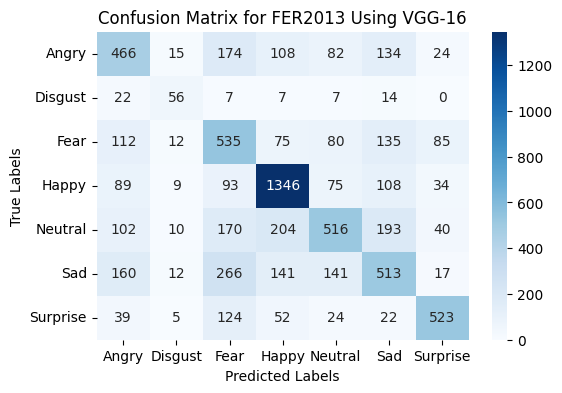

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define the class names
classes = ['Angry', 'Disgust', 'Fear', 'Happy',  'Neutral', 'Sad', 'Surprise']

# After training, use the trained model to make predictions
y_pred = model.predict(X_test)

# Convert the predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for FER2013 Using VGG-16')
plt.show()

VGG - PLOTTING THE ROC CURVE PLOT - FER2013

225/225 [==============================] - 106s 472ms/step


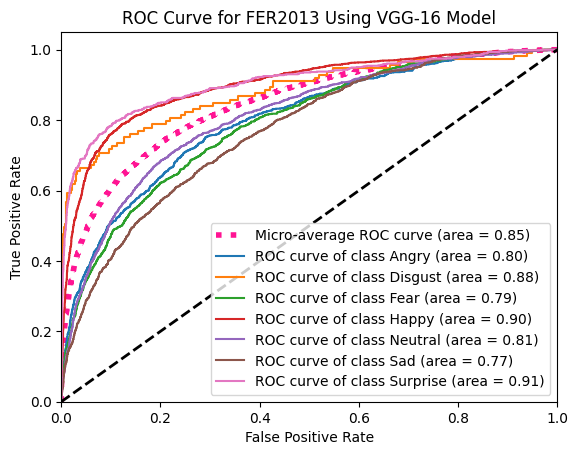

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define the class names
classes = ['Angry', 'Disgust', 'Fear', 'Happy',  'Neutral', 'Sad', 'Surprise']

def plot_roc_curve(y_true, y_pred, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'
                                               ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for FER2013 Using VGG-16 Model')
    plt.legend(loc="lower right")
    plt.show()

# Use the VGG16 model to compute the predicted probabilities for each class
y_pred_vgg16_proba = model.predict(X_test)

# Plot the ROC curve
plot_roc_curve(y_test, y_pred_vgg16_proba, classes)